# Analyze for migration communities by years

In [1]:
import pandas as pd
import pandas as pd
import networkx as nx
import geopandas as gpd
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from networkx.algorithms.community import greedy_modularity_communities


In [2]:
total_migri = pd.read_csv("data/total_binned_mun_migri.csv", index_col=0)

## Community detection

In [3]:
agg_migri = total_migri.groupby(['Arrival', 'Departure'], as_index=False)['Migration'].sum()

In [4]:
# Build directed graph
G = nx.DiGraph()
for _, row in agg_migri.iterrows():
    G.add_edge(row['Arrival'], row['Departure'], weight=row['Migration'])


In [5]:
G_undirected = G.to_undirected()

communities = list(greedy_modularity_communities(G_undirected, weight='weight'))

In [6]:
# Map municipalities to their group

comms = []
muns = []
for i, comm in enumerate(communities):
    #print(f"Community {i+1}: {comm}")
    for c in comm:
        muns.append(c)
        comms.append(i)

df_comms = pd.DataFrame({"Municipality": muns, "Community": comms})

## Plot on map

In [7]:
with open("data/finland.pkl", "rb") as f:
    finland = pickle.load(f)

finland.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta4500k.1,005,2025,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 362458.797 6..."
1,kunta4500k.2,009,2025,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 372645.944 7..."
2,kunta4500k.3,010,2025,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 345569.224 6..."
3,kunta4500k.4,016,2025,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.68 6798279.085, 435912.756 67..."
4,kunta4500k.5,018,2025,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 432565.266 6..."


In [8]:
all_community_info = []

for bin_label, bin_df in total_migri.groupby('bin'):
    
    # aggregate flows for this bin
    agg = bin_df.groupby(['Arrival', 'Departure'], as_index=False)['Migration'].sum()
    
    # migration graph
    G = nx.DiGraph()
    for _, row in agg.iterrows():
        G.add_edge(row['Departure'], row['Arrival'], weight=row['Migration'])
    communities = list(nx.algorithms.community.greedy_modularity_communities(G.to_undirected(), weight='weight'))
    
    # total arrivals
    arrivals = bin_df.groupby('Arrival')['Migration'].sum()
    
    # municipality with max arrivals as the main
    for i, comm in enumerate(communities):
        comm_list = list(comm)
        arrivals_in_comm = arrivals[arrivals.index.isin(comm_list)]
        if not arrivals_in_comm.empty:
            anchor = arrivals_in_comm.idxmax()
        else:
            anchor = comm_list[0]  # fallback
        all_community_info.append({
            'bin': bin_label,
            'community': i,
            'municipalities': comm_list,
            'main': anchor
        })


In [9]:
# unique main municipalities across bins
mains = sorted(set(info['main'] for info in all_community_info))
color_map = {main: color for main, color in zip(mains, plt.cm.tab20.colors)}

# assign color to each community based on its main community
for info in all_community_info:
    info['color'] = color_map[info['main']]

In [10]:
bin_maps = {}
for bin_label in total_migri['bin'].unique():
    comms = [info for info in all_community_info if info['bin'] == bin_label]
    rows = []
    for info in comms:
        for mun in info['municipalities']:
            rows.append({'name': mun, 'community': info['community'], 
                         'color': info['color'], 'main': info['main']})
    bin_maps[bin_label] = pd.DataFrame(rows)

In [11]:
bin_legends = {}
for bin_label, community_df in bin_maps.items():
    # one entry per community (main municipality)
    legend_entries = community_df.drop_duplicates(subset=['community'])
    legend_list = [
        (row['community'], row['color'], row['main'])  # (community index, color, anchor name)
        for _, row in legend_entries.iterrows()
    ]
    bin_legends[bin_label] = legend_list

In [12]:
# add alpha to all but the main municipalities

first_bin_label = list(bin_maps.keys())[0]
main_names = set(bin_maps[first_bin_label].drop_duplicates('community')['main'])

def color_with_alpha(row, main_names):
    if pd.isna(row['color']):
        return (1.0, 1.0, 1.0, 1.0)  # white for unassigned
    elif row['name'] in main_names:
        return mcolors.to_rgba(row['color'], alpha=1.0)
    else:
        return mcolors.to_rgba(row['color'], alpha=0.75)

def line_widths(row, main_names):
    if row['name'] in main_names:
        return 0.5
    else:
        return 0.2

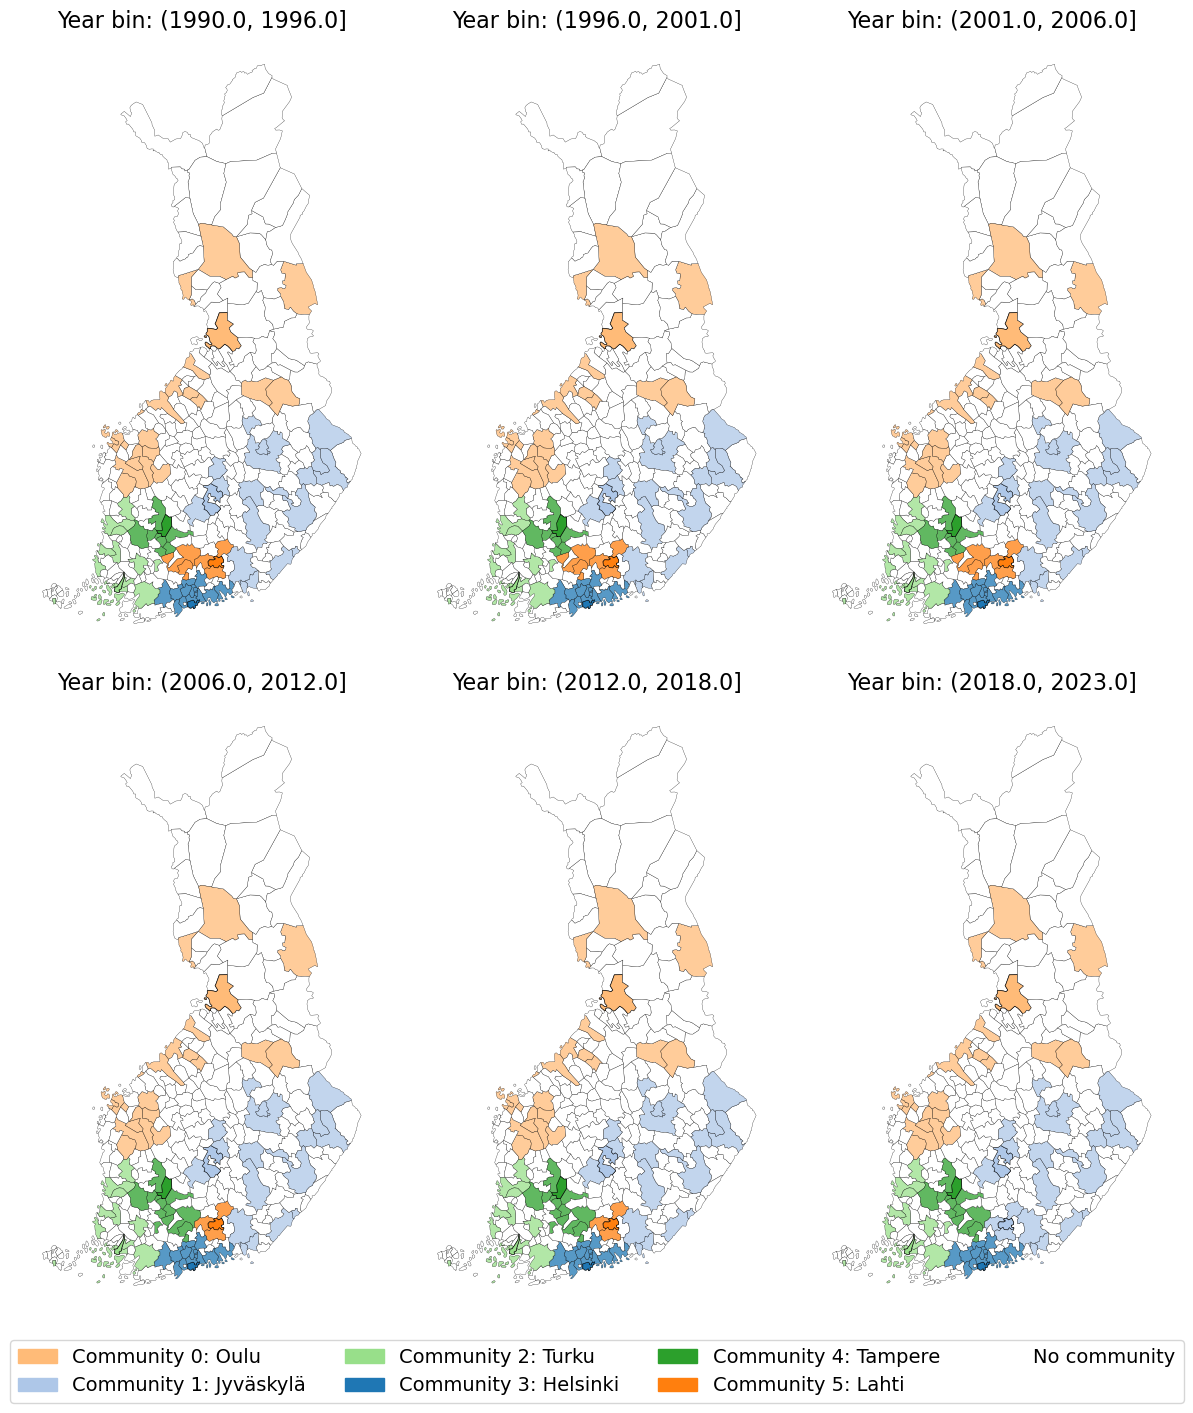

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 14))
axes = axes.flatten()

for i, (bin_label, community_df) in enumerate(bin_maps.items()):
    gdf_merged = finland.merge(community_df, on='name', how='left')
    gdf_merged['plot_color'] = gdf_merged.apply(lambda row: color_with_alpha(row, main_names), axis=1)
    gdf_merged['line_widths'] = gdf_merged.apply(lambda row: line_widths(row, main_names), axis=1)

    gdf_merged.plot(
        # color=gdf_merged['color'].fillna('white'),
        color=gdf_merged['plot_color'],
        ax=axes[i],
        edgecolor='black',
        # linewidth=0.2,
        linewidth=gdf_merged['line_widths']
    )
    axes[i].set_title(f"Year bin: {bin_label}", fontsize=16)
    axes[i].axis('off')

# Build legend handles from the first bin
first_bin_label = list(bin_maps.keys())[0]
legend_entries = bin_maps[first_bin_label].drop_duplicates(subset=['community'])
handles = [
    mpatches.Patch(color=row['color'], label=f"Community {row['community']}: {row['main']}")
    for _, row in legend_entries.iterrows()
]
handles.append(mpatches.Patch(color='white', label='No community'))

# Place the legend below all subplots
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=4,  # Adjust columns for compactness
    fontsize=14,
    frameon=True,
    bbox_to_anchor=(0.5, -0.02),  # Centered below the figure
)

plt.tight_layout(rect=(0, 0.04, 1, 1))  # Leave space at bottom for legend
# plt.savefig("images/mun_communities.png", dpi=300)

Quite interestingly we see that the Lahti Community has been eaten away by other communities, mostly Tampere and Jyväskylä.